In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
%config InlineBackend.figure_format = 'svg'

Загрузка данных и первичный осмотр

In [3]:
data = pd.read_csv("S02-hw-dataset.csv")
data.head()

,user_id,age,country,purchases,revenue
0,1,25.0,FR,7,749
1,2,24.0,RU,5,1115
2,3,52.0,FR,7,399
3,4,31.0,RU,6,654
4,5,NaN,DE,6,1296


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB


In [5]:
data.describe()

,user_id,age,purchases,revenue
count,41.000000,39.000000,41.000000,41.000000
mean,20.243902,36.512821,4.829268,820.048780
std,11.659289,18.304259,2.710189,613.127269
min,1.000000,5.000000,-1.000000,0.000000
25%,10.000000,24.000000,3.000000,432.000000
50%,20.000000,33.000000,5.000000,693.000000
75%,30.000000,45.500000,7.000000,1115.000000
max,40.000000,120.000000,11.000000,2475.000000


Пропуски, дубликаты и базовый контроль качества

In [6]:
data.isna().mean()

user_id      0.00000
age          0.04878
country      0.00000
purchases    0.00000
revenue      0.00000
dtype: float64

In [7]:
data.duplicated().sum()

np.int64(1)

In [8]:
data[data['purchases'] < 0]

,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785


In [9]:
data[data['revenue'] < 0]

,user_id,age,country,purchases,revenue


In [10]:
data[data['age'] > 100]

,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785


In [11]:
data[(data['revenue'] == 0) & (data['purchases'] != 0)]

,user_id,age,country,purchases,revenue
10,11,24.0,US,4,0


In [12]:
data[(data['revenue'] != 0) & (data['purchases'] == 0)]

,user_id,age,country,purchases,revenue


были обнаружены проблемы качества данных: неполнота(пропущенные значения в столбце 'age'), избыточность(наличие полнота дубликата строки), неточность(1 строка с ворастом >100, 1 строка с отрицательными покупками, 1 строка с нулевым доходом при ненулевых продажах)

In [13]:
data = data.dropna()

In [14]:
data = data.drop_duplicates()

In [15]:
data = data.drop(data[data['age'] > 100].index)

In [16]:
data = data.drop(data[(data['revenue'] == 0) & (data['purchases'] != 0)].index)

In [19]:
data['age'] = data.age.astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 0 to 39
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    36 non-null     int64 
 1   age        36 non-null     int64 
 2   country    36 non-null     object
 3   purchases  36 non-null     int64 
 4   revenue    36 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 1.7+ KB


Базовый EDA: группировки, агрегаты и частоты

In [57]:
data["country"].value_counts()

country
RU    12
FR    11
US     6
DE     5
CN     2
Name: count, dtype: int64

In [60]:
data['purchases'].value_counts()

purchases
7     7
6     7
3     5
5     4
0     3
4     3
2     3
9     1
8     1
11    1
1     1
Name: count, dtype: int64

In [89]:
sum_revenue_by_country = data.groupby('country')['revenue'].sum().reset_index().set_index('country')
sum_revenue_by_country

,revenue
country,
CN,2108
DE,7377
FR,7326
RU,9760
US,3829


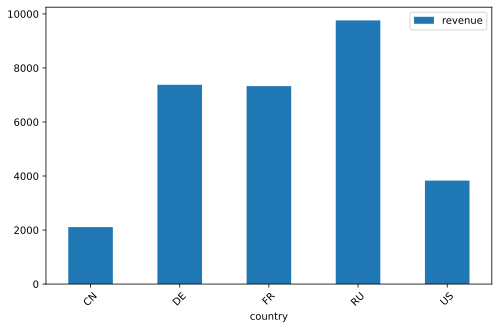

In [90]:
gistogramm_by_country = sum_revenue_by_country.plot(kind='bar', rot=45)
plt.savefig('figures/histogramm_revenue_by_country.png')

In [91]:
bins = [0, 20, 30, 40, 50, 60, 100]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '60+']
data['age_category'] = pd.cut(data['age'], bins=bins, labels=labels)
sum_revenue_by_age = data.groupby('age_category',observed=True)['revenue'].sum().reset_index().set_index('age_category')
sum_revenue_by_age

,revenue
age_category,
0-20,4244
21-30,5189
31-40,13379
41-50,4008
51-60,3580


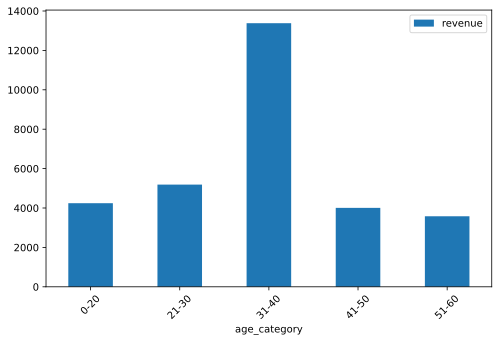

In [92]:
gistogramm_sum_revenue_by_age = sum_revenue_by_age.plot(kind='bar', rot=45)
plt.savefig('figures/histogramm_revenue_by_age.png')

In [93]:
mean_revenue_by_contry_and_age = (data.groupby(['age_category', 'country'], observed=True)['revenue'].mean().unstack().reindex(labels).fillna(0))
mean_revenue_by_contry_and_age

country,CN,DE,FR,RU,US
age_category,,,,,
0-20,1652.0,1104.0,0.000000,1488.000000,0.0
21-30,456.0,0.0,310.666667,671.200000,445.0
31-40,0.0,1857.0,1105.333333,1060.666667,655.0
41-50,0.0,0.0,922.000000,216.000000,866.0
51-60,0.0,702.0,411.333333,1302.000000,342.0
60+,0.0,0.0,0.000000,0.000000,0.0


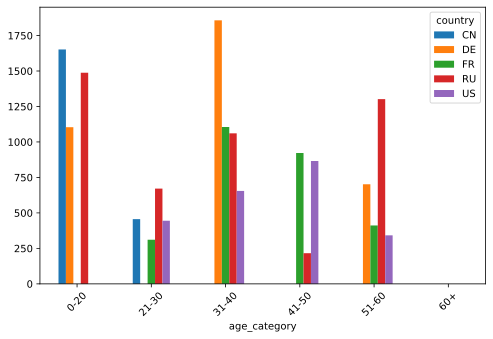

In [94]:
mean_revenue_by_contry_and_age.plot(kind='bar', rot=45)
plt.savefig('figures/histogramm_mean_revenue_by_contry_and_age.png')

Наибольшие суммарный доход среди всех возрастов мы заметили в группе 31-40 лет. Наибольшие суммарный доход среди всех стран мы заметили в России. При этом наибольший средний чек у группы 31-40 лет в Германии

Визуализация данных в Matplotlib

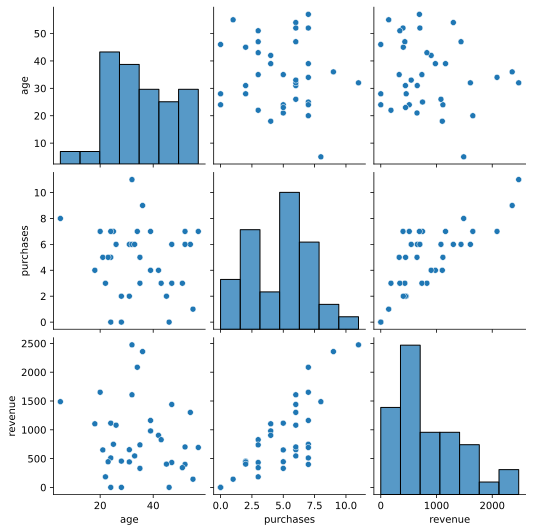

In [43]:
cols = ['age', 'purchases', 'revenue']
sns_plot = sns.pairplot(data[cols])
plt.savefig('figures/pairplot.png')

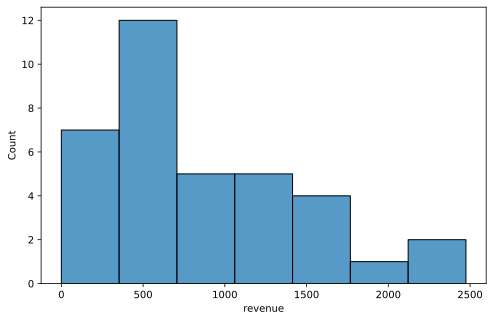

In [51]:
sns.histplot(data.revenue)
plt.savefig('figures/histogram_revenue.png')

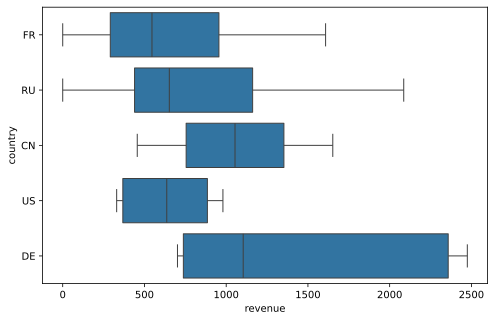

In [50]:
sns.boxplot(y="country", x="revenue", data=data, orient="h")
plt.savefig('figures/boxplot_revenue.png')

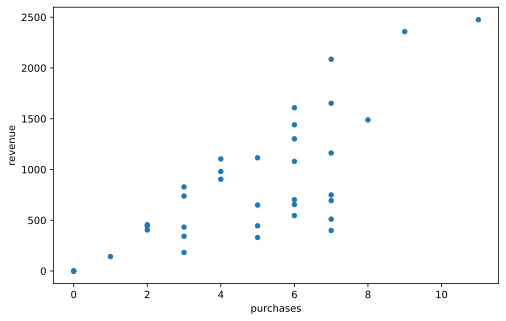

In [54]:
data.plot(x="purchases", y="revenue", kind="scatter")
plt.savefig('figures/scatter_plot_revenue.png')